# Interactive Cell Classification and Analysis

## Introduction
This notebook allows you to classify and analyze cells in a grayscale image using an interactive approach. The goal is to identify and highlight infected cells based on how much dark pixels that they contain. You can adjust **infection_threshold** the **minimum** and **maximum size** of the regions (cells) interactively using sliders to explore how these parameters affect the cell classification.

## How to Use
1. **Min Size Adjustments**: Use the "Min Size" slider to adjust the minimum size of a region to be considered as a valid cell. The lower this value, the more small regions will be considered as cells.
2. **Max Size Adjustments**: Use the "Max Size" slider to adjust the maximum size of a region to be considered as a valid cell. Increasing this will consider larger regions as cells.
3. **Malaria Infected Cell Detection**: Infected cells are identified based on the percentage of dark pixels in each region. The **min_infected_percentage** parameter can be adjusted to define the threshold at which a cell is considered "infected".
4. **Threshold Value**: Modifies how the sobel edge detection works and how each cell region is defined.

## Outputs
- **Labeled Image**: The image where different cells are labeled with unique grayscale values from 0.5 - 1.0.
- **Histogram**: The distribution of pixel values in the labeled image.
- **Infected Cell Count**: The number of cells that are considered infected based on the defined threshold.

Firstly at the bottom of the next cell: **change your image -->** "image = plt.imread("malaria_1.jpeg")"

Then modify the parameters to fine tune:  "cells_infected = run(image, threshold_value = 0.038, min_size = 2000, max_size = 5000, min_infected_percentage=0.02)" 

If you are unhappy with the results change either the size or threshold and retest.

---

### Note: 
Make sure image data used in this notebook is pre-processed and formatted correctly for optimal results.



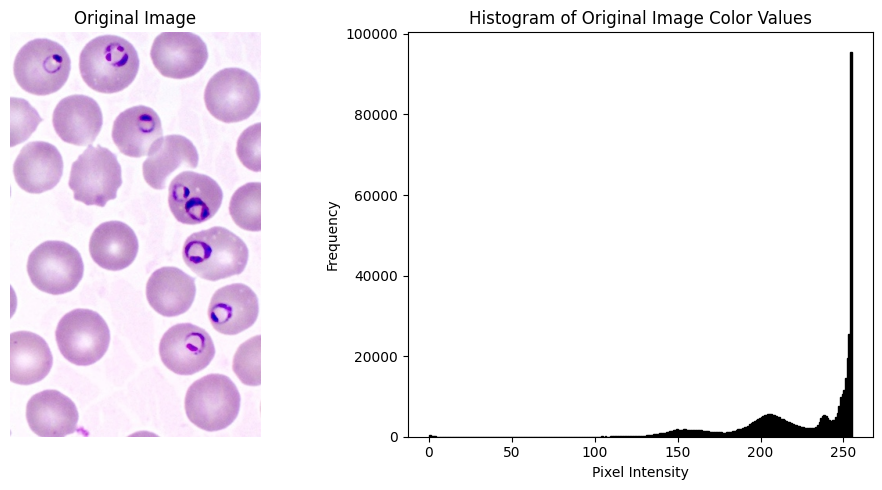

Number of labeled areas is: 47


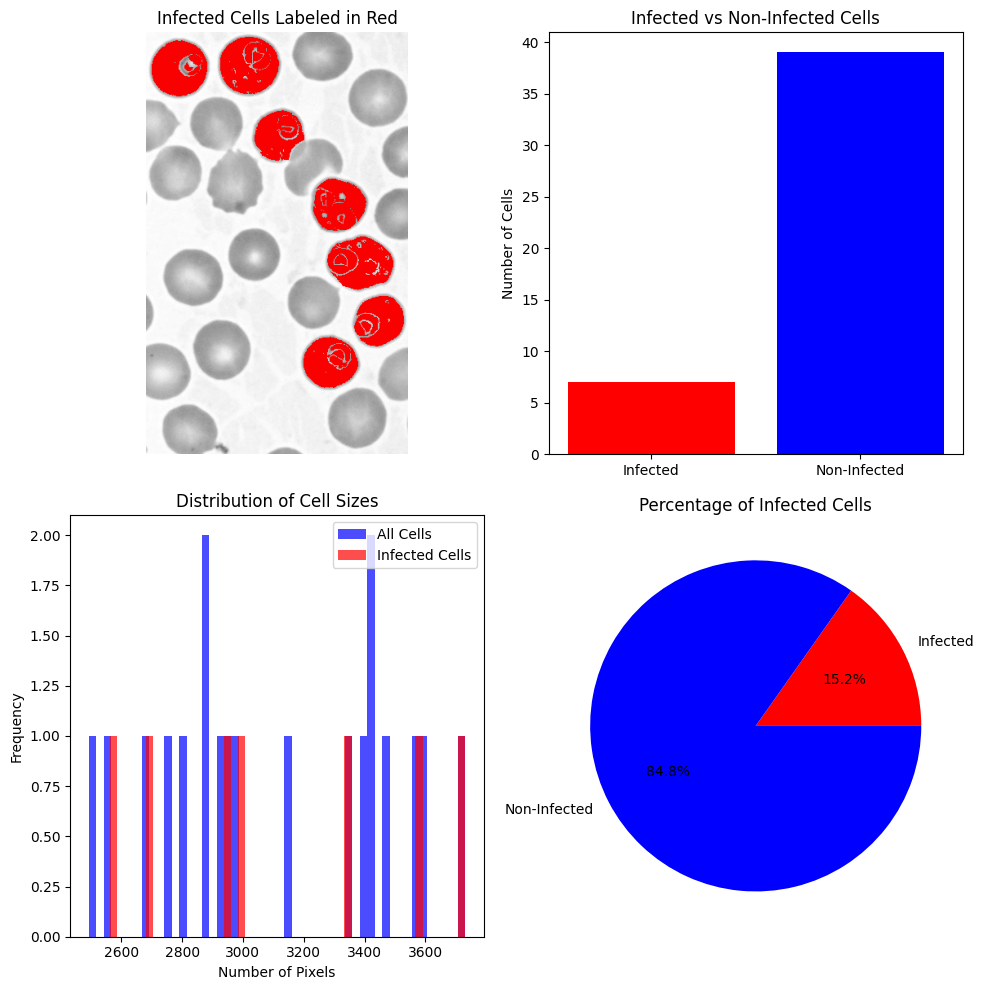

Total number of cells: 46
Number of infected cells: 7
Percentage of infected cells: 15.22%


In [ ]:
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
from skimage.filters import sobel
import cv2

def fill_cells(edge_image):
    """
    Args:
        edge_image: A black-and-white image, with black background and
                    white edges.
    Returns:
        A new image where the background is black, the edges are white, and
        each enclosed region is filled with a unique grayscale value.
    """
    # Ensure the input image is binary (0 for black, 1 for white edges)
    edge_image = np.uint8(np.clip(edge_image * 255, 0, 255))  # Convert to 0-255 binary

    # Invert the image so the edges are black (0) and the enclosed areas are white (255)
    inverted_image = 255 - edge_image

    # Step 1: Find all the connected components (regions) in the inverted image
    num_labels, labels = cv2.connectedComponents(inverted_image)

    print(f"Number of labeled areas is: {num_labels}") # backround + enclosed spaces

    # Create a copy of the original edge image to fill enclosed regions
    filled_image = edge_image.copy()

    # Step 2: Iterate through labeled regions and fill each with a unique grayscale value
    n_regions_found_so_far = 0
    for label in range(1, num_labels):  # Start from 1, as 0 is the background (black)
        # Generate a unique grayscale value for each region
        region_fill_color = 128 + (int(128//num_labels) * n_regions_found_so_far)  # Starting from 0.5, incrementing
        
        # Ensure the region_fill_color does not exceed 1.0
        #region_fill_color = min(region_fill_color, 1.0)  # Clamp to 1.0 if it exceeds

        # Fill all pixels in this region with the region's unique grayscale value
        filled_image[labels == label] = region_fill_color  # Scale to 0-255 for visualization
        n_regions_found_so_far += 1

    '''
    # Some non bounded areas are ignored in the infection count.
    # See this image (remove quotes) to visualize, try adjusting threshold
    filled_image = np.uint8(np.clip(filled_image * 255, 0, 255)) 
    # Visualize the final filled image with unique grayscale fill
    plt.imshow(filled_image, cmap='gray')
    plt.title("Final Image with Unique Grayscale Fill")
    plt.axis('off')  # Turn off axis for a cleaner image
    plt.show()
    '''
    return filled_image

def find_coordinates_for_greyscale(labeled_image, greyscale_val):
    """
    Function to find all coordinates of the pixels that match the given `greyscale_val` in the labeled image.
    Args:
        labeled_image: The labeled image where each pixel has a grayscale value.
        greyscale_val: The grayscale value for which coordinates are to be found.
    Returns:
        A list of (row, col) coordinates where the pixel matches `greyscale_val`.
    """
    coordinates = []
    n_rows, n_cols = labeled_image.shape
    
    for i in range(n_rows): 
        for j in range(n_cols):
            if labeled_image[i, j] == greyscale_val:
                coordinates.append((i, j))
    
    return coordinates

def ensure_rgb_format(image):
    """
    Ensure the image is in RGB format.
    If the image is grayscale, convert it to RGB by repeating the grayscale values across 3 channels.
    Args:
        image: Input image, which might be grayscale.
    Returns:
        RGB image.
    """
    if len(image.shape) == 2:  # If the image is grayscale (2D array)
        image_rgb = np.stack((image,)*3, axis=-1)  # Stack the grayscale image to create 3 channels
    elif image.shape[2] == 1:  # If the image has a single channel but 3D
        image_rgb = np.repeat(image, 3, axis=-1)  # Repeat the single channel across 3 channels
    else:
        image_rgb = image  # Already in RGB format
    return image_rgb

def classify_cells(original_image, labeled_image, \
                   min_size, max_size, \
                   infected_grayscale, \
                    min_infected_percentage):

    n_row, n_col = original_image.shape

    # Ensure original_image is in RGB format
    rgb_image = ensure_rgb_format(original_image)

    # Builds a set of all grayscale values (cells) in the labeled image
    grayscales = {labeled_image[i,j] for i in range(n_row) for j in range(n_col) \
                  if labeled_image[i,j] >= 120 and labeled_image[i,j] < 255}

    # sets rows and cols to the labeled image array [i,j] 
    n_rows, n_cols = labeled_image.shape

    # Total number of cells (before applying the size filter)
    total_cells = len(grayscales)
    #print(f"total cells is: {total_cells}")

    # Initialize a list to track cell sizes
    cell_sizes = []
    infected_sizes = []
    
    # Initailize a count of infected cells and store infected cell sizes
    infected = 0
    infected_cells_coords = {}
    
    #---------Pixel Iteration----------#
    for greyscale_val in grayscales:
        row_list = []
        col_list = []    
        coordinates_to_check = [] 
        
        for i in range(n_rows):
            for j in range(n_cols):
                if labeled_image[i,j] == greyscale_val:
                    col_list.append(j)
                    row_list.append(i)
                    coordinates_to_check.append([i,j])
        
        # Calculate cell size
        total_pixels = len(coordinates_to_check)
        if total_pixels < min_size or total_pixels > max_size:
            continue
        
        # Track cell size
        cell_sizes.append(total_pixels)

        dark_count = 0
        for coor in coordinates_to_check:
            if original_image[coor[0]][coor[1]] < infected_grayscale:
                dark_count +=1
        
        percent = dark_count / total_pixels
        if percent >= min_infected_percentage:
            infected += 1
            infected_sizes.append(total_pixels)

            coords = find_coordinates_for_greyscale(labeled_image, greyscale_val)
            infected_cells_coords[greyscale_val] = coords

            for i, j in zip(row_list, col_list):
                rgb_image[i, j] = [250/255, 1/255, 1/255]  # Scale values to [0, 1]
                #rgb_image[i, j] = [200, 1, 1]  # Red color (RGB)

    #---------Figure generation----------#
    # Define the grid layout for subplots (2 rows and 2 columns for 4 plots)
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    # Plot the labeled image
    #axs[0, 0].imshow(original_image)
    #axs[0, 0].set_title("IGrayscale Image")
    axs[0, 0].imshow(rgb_image)
    axs[0, 0].set_title("Infected Cells Labeled in Red")
    axs[0, 0].axis('off')

    # Histogram of grayscale values in labeled image
    #axs[0, 1].hist(labeled_image.ravel(), bins=range(256), fc='k', ec='k')
    #axs[0, 1].set_title('Histogram of Labeled Image Grayscale Values')

    # Plot the infected vs non-infected cells count
    non_infected = total_cells - infected
    axs[0, 1].bar(['Infected', 'Non-Infected'], [infected, non_infected], color=['red', 'blue'])
    axs[0, 1].set_title('Infected vs Non-Infected Cells')
    axs[0, 1].set_ylabel('Number of Cells')

    # Plot the distribution of cell sizes (all cells and infected cells)
    axs[1, 0].hist(cell_sizes, bins=50, color='blue', alpha=0.7, label='All Cells')
    axs[1, 0].hist(infected_sizes, bins=50, color='red', alpha=0.7, label='Infected Cells')
    axs[1, 0].legend()
    axs[1, 0].set_title('Distribution of Cell Sizes')
    axs[1, 0].set_xlabel('Number of Pixels')
    axs[1, 0].set_ylabel('Frequency')

    # Plot the percentage of infected cells as a pie chart
    #infected_percentage = (infected / total_cells) * 100

    if total_cells == 0:
        print("Warning: No cells detected.")
        infected_percentage = 0  # Set the infected percentage to 0 if no cells are detected.
    else:
        infected_percentage = (infected / total_cells) * 100

    axs[1, 1].pie([infected_percentage, 100 - infected_percentage], 
                  labels=['Infected', 'Non-Infected'], autopct='%1.1f%%', colors=['red', 'blue'])
    axs[1, 1].set_title('Percentage of Infected Cells')

    # Adjust layout for a clean fit
    plt.tight_layout()

    # Show the entire figure
    plt.show()

    # Print summary
    print(f'Total number of cells: {total_cells}')
    print(f'Number of infected cells: {infected}')
    print(f'Percentage of infected cells: {infected_percentage:.2f}%')

    return infected, rgb_image, infected_cells_coords

def run(image, threshold_value, min_size, max_size, min_infected_percentage):

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns, adjust size as needed

    # Plot original image on the first subplot
    axs[0].imshow(image, cmap='gray')  # Displaying the image (grayscale or RGB)
    axs[0].set_title("Original Image")  # Title for the original image
    axs[0].axis('off')  # Optional: turn off axis for a cleaner display

    # Plot histogram of the original image on the second subplot
    axs[1].hist(image.ravel(), bins=range(256), color='k', edgecolor='k')  # Histogram of grayscale values
    axs[1].set_title('Histogram of Original Image Color Values')  # Title for the histogram
    axs[1].set_xlabel('Pixel Intensity')  # Label for the x-axis
    axs[1].set_ylabel('Frequency')  # Label for the y-axis

    # Adjust layout for clean presentation
    plt.tight_layout()
    # Show the entire figure
    plt.show()

    # Converting the image to graytone
    image_gray = rgb2gray(image)
    image_sobel = sobel(image_gray)
    
    image_sobel_T005 = np.where(image_sobel >= threshold_value, 1.0, 0.0)
    
    n_row, n_col = image_sobel_T005.shape

    sobel_clean = image_sobel_T005.copy()
    for i in range(n_row):
        for j in range(n_col):
            if np.min(image_gray[max(0,i-1):min(n_row,i+2), max(0,j-1):min(n_col,j+2)])<0.5:
                sobel_clean[i,j] = 0
    image_filled = fill_cells(sobel_clean)

    if image_filled is None:
        print("Error: fill_cells() did not return a valid image.")

    if image_gray is None:
        print("Error: labeled_image is None.")
    
    infected_grayscale=0.5
    cell_data = classify_cells(image_gray, image_filled, min_size, max_size, infected_grayscale, min_infected_percentage)
    
    return cell_data[0]

if __name__ == "__main__":  
    
    #### Specify which image you want! ####
    image = plt.imread("malaria_1.jpeg")

    cells_infected = run(image, threshold_value = 0.038, min_size = 2000, max_size = 5000, min_infected_percentage=0.02)

